# pomegranate / hmmlearn comparison

<a href="https://github.com/hmmlearn/hmmlearn">hmmlearn</a> is a Python module for hidden markov models with a scikit-learn like API. It was originally present in scikit-learn until its removal due to structural learning not meshing well with the API of many other classical machine learning algorithms. Here is a table highlighting some of the similarities and differences between the two packages.

<table>
<tr>
<th>Feature</th>
<th>pomegranate</th>
<th>hmmlearn</th>
</tr>
<tr>
<th>Graph Structure</th>
<th></th>
<th></th>
</tr>
<tr>
<td>Silent States</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Optional Explicit End State</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Sparse Implementation</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Arbitrary Emissions Allowed on States</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Discrete/Gaussian/GMM Emissions</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Large Library of Other Emissions</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Build Model from Matrices</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Build Model Node-by-Node</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Serialize to JSON</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Serialize using Pickle/Joblib</td>
<td></td>
<td>&#10003;</td>
</tr>
<tr>
<th>Algorithms</th>
<th></th>
<th></th>
</tr>
<tr>
<td>Priors</td>
<td></td>
<td>&#10003;</td>
</tr>
<tr>
<td>Sampling</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Log Probability Scoring</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Forward-Backward Emissions</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Forward-Backward Transitions</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Viterbi Decoding</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>MAP Decoding</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Baum-Welch Training</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Viterbi Training</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Labeled Training</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Tied Emissions</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Tied Transitions</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Emission Inertia</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Transition Inertia</td>
<td>&#10003;</td>
<td></td>
</tr>
<tr>
<td>Emission Freezing</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Transition Freezing</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td>Multi-threaded Training</td>
<td>&#10003;</td>
<td>Coming Soon</td>
</tr>

</table>
</p>

Just because the two features are implemented doesn't speak to how fast they are. Below we investigate how fast the two packages are in different settings the two have implemented. 

## Fully Connected Graphs with Multivariate Gaussian Emissions

Lets look at the sample scoring method, viterbi, and Baum-Welch training for fully connected graphs with multivariate Gaussian emisisons. A fully connected graph is one where all states have connections to all other states. This is a case which pomegranate is expected to do poorly due to its sparse implementation, and hmmlearn should shine due to its vectorized implementations.

In [1]:
%pylab inline
import hmmlearn, pomegranate, time, seaborn
from hmmlearn.hmm import *
from pomegranate import *
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


Both hmmlearn and pomegranate are under active development. Here are the current versions of the two packages.

In [2]:
print "hmmlearn version {}".format(hmmlearn.__version__)
print "pomegranate version {}".format(pomegranate.__version__)

hmmlearn version 0.2.0
pomegranate version 0.4.0


We first should have a function which will randomly generate transition matrices and emissions for the hidden markov model, and randomly generate sequences which fit the model.

In [3]:
def initialize_components(n_components, n_dims, n_seqs):
    """
    Initialize a transition matrix for a model with a fixed number of components,
    for Gaussian emissions with a certain number of dimensions, and a data set
    with a certain number of sequences.
    """
    
    transmat = numpy.abs(numpy.random.randn(n_components, n_components))
    transmat = (transmat.T / transmat.sum( axis=1 )).T

    start_probs = numpy.abs( numpy.random.randn(n_components) )
    start_probs /= start_probs.sum()

    means = numpy.random.randn(n_components, n_dims)
    covars = numpy.ones((n_components, n_dims))
    
    seqs = numpy.zeros((n_seqs, n_components, n_dims))
    for i in range(n_seqs):
        seqs[i] = means + numpy.random.randn(n_components, n_dims)
        
    return transmat, start_probs, means, covars, seqs

Lets create the model in hmmlearn. It's fairly straight forward, only some attributes need to be overridden with the known structure and emissions.

In [4]:
def hmmlearn_model(transmat, start_probs, means, covars):
    """Return a hmmlearn model."""

    model = GaussianHMM(n_components=transmat.shape[0], covariance_type='diag', n_iter=1, tol=1e-8)
    model.startprob_ = start_probs
    model.transmat_ = transmat
    model.means_ = means
    model._covars_ = covars
    return model

Now lets create the model in pomegranate. Also fairly straightforward. The biggest difference is creating explicit distribution objects rather than passing in vectors, and passing everything into a function instead of overriding attributes. This is done because each state in the graph can be a different distribution and many distributions are supported.

In [5]:
def pomegranate_model(transmat, start_probs, means, covars):
    """Return a pomegranate model."""
    
    states = [ MultivariateGaussianDistribution( means[i], numpy.eye(means.shape[1]) ) for i in range(transmat.shape[0]) ]
    model = HiddenMarkovModel.from_matrix(transmat, states, start_probs, merge='None')
    return model

Lets now compare some algorithm times.

In [6]:
def evaluate_models(n_dims, n_seqs):
    hllp, plp = [], []
    hlv, pv = [], []
    hlm, pm = [], []
    hls, ps = [], []
    hlt, pt = [], []

    for i in range(10, 112, 10):
        transmat, start_probs, means, covars, seqs = initialize_components(i, n_dims, n_seqs)
        model = hmmlearn_model(transmat, start_probs, means, covars)

        tic = time.time()
        for seq in seqs:
            model.score(seq)
        hllp.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict(seq)
        hlv.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict_proba(seq)
        hlm.append( time.time() - tic )    
        
        tic = time.time()
        model.fit(seqs.reshape(n_seqs*i, n_dims), lengths=[i]*n_seqs)
        hlt.append( time.time() - tic )

        model = pomegranate_model(transmat, start_probs, means, covars)

        tic = time.time()
        for seq in seqs:
            model.log_probability(seq)
        plp.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict(seq)
        pv.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict_proba(seq)
        pm.append( time.time() - tic )    
        
        tic = time.time()
        model.fit(seqs, max_iterations=1, verbose=False)
        pt.append( time.time() - tic )

    plt.figure( figsize=(12, 8))
    plt.xlabel("# Components", fontsize=12 )
    plt.ylabel("pomegranate is x times faster", fontsize=12 )
    plt.plot( numpy.array(hllp) / numpy.array(plp), label="Log Probability")
    plt.plot( numpy.array(hlv) / numpy.array(pv), label="Viterbi")
    plt.plot( numpy.array(hlm) / numpy.array(pm), label="Maximum A Posteriori")
    plt.plot( numpy.array(hlt) / numpy.array(pt), label="Training")
    plt.xticks( xrange(11), xrange(10, 112, 10), fontsize=12 )
    plt.yticks( fontsize=12 )
    plt.legend( fontsize=12 )

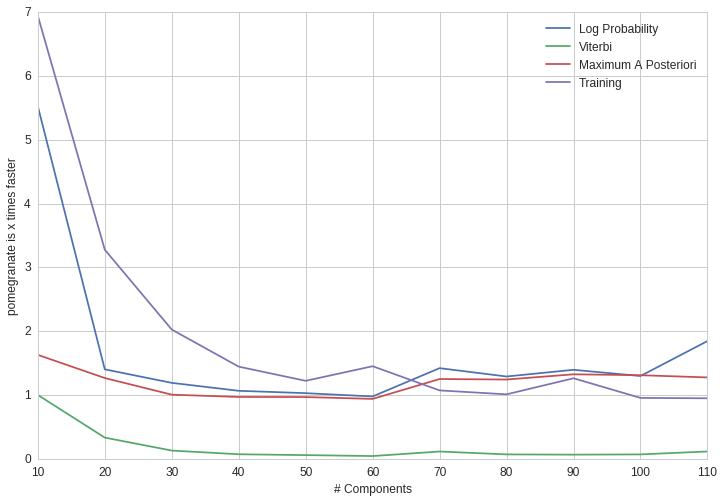

In [7]:
evaluate_models(10, 50)

It looks like in this case pomegranate and hmmlearn are approximately the same for large (>30 components) dense graphs for the forward algorithm (log probability), MAP, and training. However, hmmlearn is significantly faster in terms of calculating the Viterbi path, while pomegranate is faster for smaller (<30 components) graphs.

## Sparse Graphs with Multivariate Gaussian Emissions

pomegranate is based off of a sparse implementations and so excels in graphs which are sparse. Lets try a model architecture where each hidden state only has transitions to itself and the next state, but running the same algorithms as last time.

In [8]:
def initialize_components(n_components, n_dims, n_seqs):
    """
    Initialize a transition matrix for a model with a fixed number of components,
    for Gaussian emissions with a certain number of dimensions, and a data set
    with a certain number of sequences.
    """
    
    transmat = numpy.zeros((n_components, n_components))
    transmat[-1, -1] = 1
    for i in range(n_components-1):
        transmat[i, i] = 1
        transmat[i, i+1] = 1
    transmat[ transmat < 0 ] = 0
    transmat = (transmat.T / transmat.sum( axis=1 )).T

    start_probs = numpy.abs( numpy.random.randn(n_components) )
    start_probs /= start_probs.sum()

    means = numpy.random.randn(n_components, n_dims)
    covars = numpy.ones((n_components, n_dims))
    
    seqs = numpy.zeros((n_seqs, n_components, n_dims))
    for i in range(n_seqs):
        seqs[i] = means + numpy.random.randn(n_components, n_dims)
        
    return transmat, start_probs, means, covars, seqs

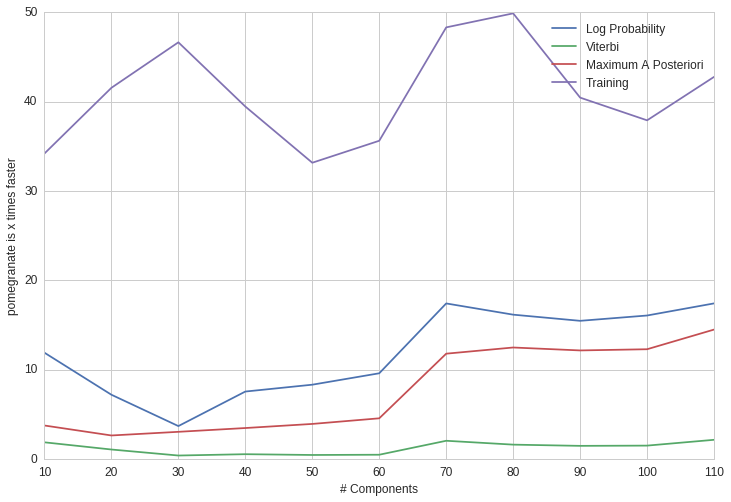

In [9]:
evaluate_models(10, 50)

## Sparse Graph with Discrete Emissions

Lets also compare MultinomialHMM to a pomegranate HMM with discrete emisisons for completeness.

In [10]:
def initialize_components(n_components, n_seqs):
    """
    Initialize a transition matrix for a model with a fixed number of components,
    for Gaussian emissions with a certain number of dimensions, and a data set
    with a certain number of sequences.
    """
    
    transmat = numpy.zeros((n_components, n_components))
    transmat[-1, -1] = 1
    for i in range(n_components-1):
        transmat[i, i] = 1
        transmat[i, i+1] = 1
    transmat[ transmat < 0 ] = 0
    transmat = (transmat.T / transmat.sum( axis=1 )).T
    
    start_probs = numpy.abs( numpy.random.randn(n_components) )
    start_probs /= start_probs.sum()

    dists = numpy.abs(numpy.random.randn(n_components, 4))
    dists = (dists.T / dists.T.sum(axis=0)).T
    
    seqs = numpy.random.randint(0, 4, (n_seqs, n_components*2, 1))
    return transmat, start_probs, dists, seqs

def hmmlearn_model(transmat, start_probs, dists):
    """Return a hmmlearn model."""

    model = MultinomialHMM(n_components=transmat.shape[0], n_iter=1, tol=1e-8)
    model.startprob_ = start_probs
    model.transmat_ = transmat
    model.emissionprob_ = dists
    return model

def pomegranate_model(transmat, start_probs, dists):
    """Return a pomegranate model."""
    
    states = [ DiscreteDistribution({ 'A': d[0],
                                      'C': d[1],
                                      'G': d[2], 
                                      'T': d[3] }) for d in dists ]
    model = HiddenMarkovModel.from_matrix(transmat, states, start_probs, merge='None')
    return model

def evaluate_models(n_seqs):
    hllp, plp = [], []
    hlv, pv = [], []
    hlm, pm = [], []
    hls, ps = [], []
    hlt, pt = [], []

    dna = 'ACGT'
    
    for i in range(10, 112, 10):
        transmat, start_probs, dists, seqs = initialize_components(i, n_seqs)
        model = hmmlearn_model(transmat, start_probs, dists)

        tic = time.time()
        for seq in seqs:
            model.score(seq)
        hllp.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict(seq)
        hlv.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict_proba(seq)
        hlm.append( time.time() - tic )    
        
        tic = time.time()
        model.fit(seqs.reshape(n_seqs*i*2, 1), lengths=[i*2]*n_seqs)
        hlt.append( time.time() - tic )

        model = pomegranate_model(transmat, start_probs, dists)
        seqs = [[dna[i] for i in seq] for seq in seqs]

        tic = time.time()
        for seq in seqs:
            model.log_probability(seq)
        plp.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict(seq)
        pv.append( time.time() - tic )

        tic = time.time()
        for seq in seqs:
            model.predict_proba(seq)
        pm.append( time.time() - tic )    
        
        tic = time.time()
        model.fit(seqs, max_iterations=1, verbose=False)
        pt.append( time.time() - tic )

    plt.figure( figsize=(12, 8))
    plt.xlabel("# Components", fontsize=12 )
    plt.ylabel("pomegranate is x times faster", fontsize=12 )
    plt.plot( numpy.array(hllp) / numpy.array(plp), label="Log Probability")
    plt.plot( numpy.array(hlv) / numpy.array(pv), label="Viterbi")
    plt.plot( numpy.array(hlm) / numpy.array(pm), label="Maximum A Posteriori")
    plt.plot( numpy.array(hlt) / numpy.array(pt), label="Training")
    plt.xticks( xrange(11), xrange(10, 112, 10), fontsize=12 )
    plt.yticks( fontsize=12 )
    plt.legend( fontsize=12 )

/home/jmschr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:77: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


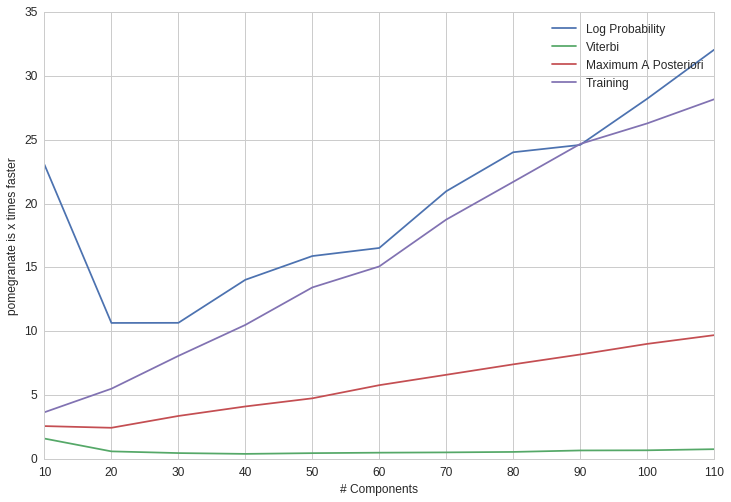

In [11]:
evaluate_models(50)